In [1]:
import torch
from sklearn import datasets

In [2]:
device = 'mps' if torch.mps.is_available() else 'cpu'

data = datasets.load_iris()
X = torch.from_numpy(data['data']).to(device=device, dtype=torch.float)
y = torch.from_numpy(data['target']).to(device=device, dtype=torch.float)

X[:5], y[:5]

(tensor([[5.1000, 3.5000, 1.4000, 0.2000],
         [4.9000, 3.0000, 1.4000, 0.2000],
         [4.7000, 3.2000, 1.3000, 0.2000],
         [4.6000, 3.1000, 1.5000, 0.2000],
         [5.0000, 3.6000, 1.4000, 0.2000]], device='mps:0'),
 tensor([0., 0., 0., 0., 0.], device='mps:0'))

In [3]:
print('The X dataset has shape {}'.format(X.shape))
print('The y dataset has shape {}'.format(y.shape))
print('The labels in y dataset are: {}'.format(torch.unique(y)))

The X dataset has shape torch.Size([150, 4])
The y dataset has shape torch.Size([150])
The labels in y dataset are: tensor([0., 1., 2.], device='mps:0')


### We know from sklearn docs that the load_iris() dataset has NO missing values. We can then skip that phase of DEA and go straight to the ML part (standardizing the data etc is not the core of the topic here, we point to crunch some data with a ML model and get experience with PyTorch instead, whatever the final accuracy is)

In [4]:
#let's split the original dataset into train and test (we know that the labels are equally spread through the three target classes from sklearn docs)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
from torch.nn import functional as F
class ClassificationNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_features=4, 
                                   out_features=20)
        self.fc2 = torch.nn.Linear(in_features=20, 
                                   out_features=40)
        self.fc3 = torch.nn.Linear(in_features=40,
                                   out_features=3)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x
    
model = ClassificationNet().to(device=device)
model

ClassificationNet(
  (fc1): Linear(in_features=4, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=3, bias=True)
)

In [6]:
for param in model.parameters():
    print(param.shape)

torch.Size([20, 4])
torch.Size([20])
torch.Size([40, 20])
torch.Size([40])
torch.Size([3, 40])
torch.Size([3])


In [7]:
LEARNING_RATE = 5e-3
epochs = 10_000
loss_fn = torch.nn.CrossEntropyLoss() #CrossEntropyLoss works with the logits
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
iteration = 0 
accuracy_hist = []
loss_hist = []

for epoch in range(epochs):
    iteration = iteration + 1
    y_hat = model(X_train)
    
    step_loss = loss_fn(y_hat, y_train)
    step_accuracy = (torch.argmax(y_hat, dim=1) == y_train).float().sum() / (y_hat.shape[0])
    step_loss.backward()
    optimizer.step()

    optimizer.zero_grad()

    if iteration % 300 == 0:
        print(f'Iteration: {iteration}, Loss: {step_loss.item():.5f}')
        print(f'\tAccuracy: {step_accuracy:.4f}\n')
    
    loss_hist.append(step_loss.item())
    accuracy_hist.append(step_accuracy.item())


Iteration: 300, Loss: 1.05897
	Accuracy: 0.3333

Iteration: 600, Loss: 0.97863
	Accuracy: 0.6833

Iteration: 900, Loss: 0.87398
	Accuracy: 0.6833

Iteration: 1200, Loss: 0.81454
	Accuracy: 0.6917

Iteration: 1500, Loss: 0.77587
	Accuracy: 0.8583

Iteration: 1800, Loss: 0.74056
	Accuracy: 0.9333

Iteration: 2100, Loss: 0.70689
	Accuracy: 0.9833

Iteration: 2400, Loss: 0.67782
	Accuracy: 0.9917

Iteration: 2700, Loss: 0.65493
	Accuracy: 0.9917

Iteration: 3000, Loss: 0.63798
	Accuracy: 0.9917

Iteration: 3300, Loss: 0.62558
	Accuracy: 0.9917

Iteration: 3600, Loss: 0.61641
	Accuracy: 0.9917

Iteration: 3900, Loss: 0.60945
	Accuracy: 0.9917

Iteration: 4200, Loss: 0.60406
	Accuracy: 0.9917

Iteration: 4500, Loss: 0.59978
	Accuracy: 0.9917

Iteration: 4800, Loss: 0.59631
	Accuracy: 0.9917

Iteration: 5100, Loss: 0.59345
	Accuracy: 0.9917

Iteration: 5400, Loss: 0.59105
	Accuracy: 0.9917

Iteration: 5700, Loss: 0.58901
	Accuracy: 0.9917

Iteration: 6000, Loss: 0.58725
	Accuracy: 0.9917

Ite

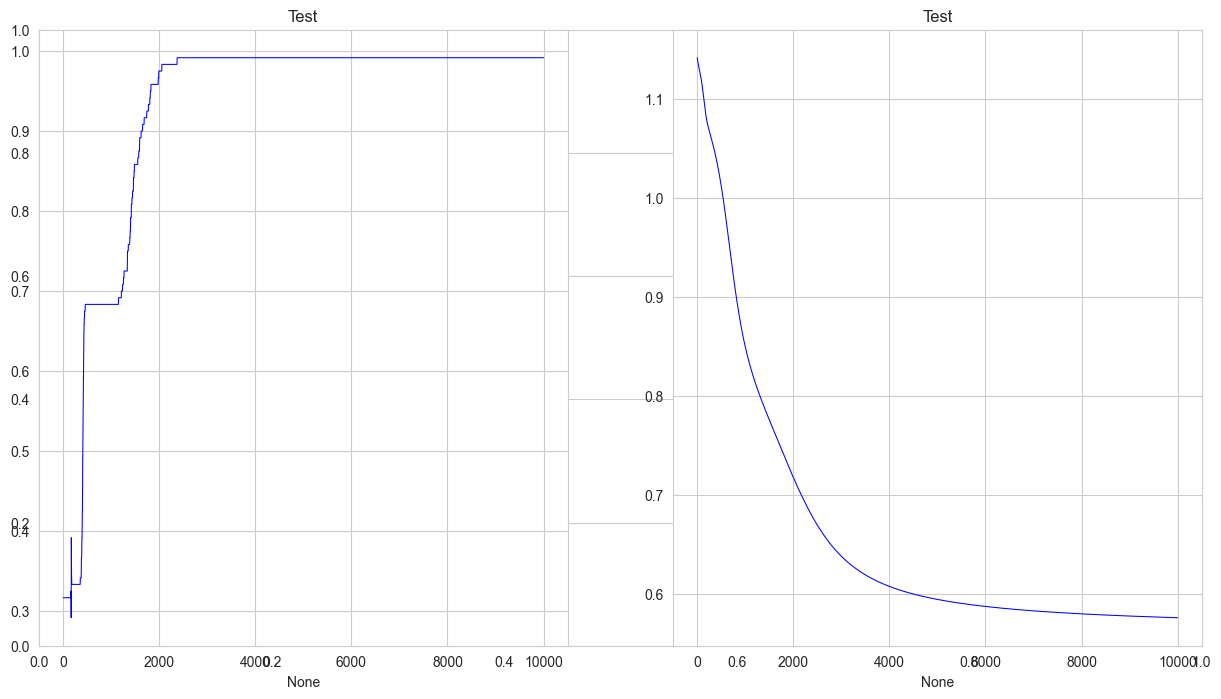

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
for idx, scorer in enumerate([accuracy_hist, loss_hist]):
    fig.add_subplot(1, 2, idx + 1)
    sns.lineplot(x=torch.arange(start=0, end=10_000, step=1), 
                 y=scorer,
                 color='blue',
                 linewidth=0.75)
    plt.title('Test')

In [ ]:
model.eval()
with torch.inference_mode():
    prediction = model(X_test)

loss_test = loss_fn(prediction, y_test)
print(f'Loss: {loss_test.item():.5f}')

prediction.argmax(dim=1)